In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint as pp

import os
import sys

import xlwt

In [2]:
AMPf = np.array([1.851, 2.082, 1.948, 2.434, 2.024, 2.198, 2.033, 0.034, 1.57, 2.165, 0.051, 0.083, 2.186, 2.322, 0.088, 2.821])
AMf  = np.array([1.778, 1.782, 2.042, 1.752, 1.448, 1.544, 1.184, 0.063, 1.72, 2.008, 1.799, 2.005, 1.557, 2.247, 1.768, 2.047])
CECf = np.array([2.258, 1.996, 2.151, 2.648, 2.396, 1.846, 2.23, 0.214, 0.234, 0.172, 2.242, 0.093, 2.15, 0.095, 2.64, 0.516])
CTXf = np.array([0.16, 0.085, 1.936, 2.348, 1.653, 0.138, 2.295, 2.269, 0.185, 0.14, 1.969, 0.203, 0.225, 0.092, 0.119, 2.412])
ZOXf = np.array([0.993, 0.805, 2.069, 2.683, 1.698, 2.01, 2.138, 2.688, 1.106, 1.171, 1.894, 0.681, 1.116, 1.105, 1.103, 2.591])
CXMf = np.array([1.748, 1.7, 2.07, 1.938, 2.94, 2.173, 2.918, 3.272, 0.423, 1.578, 1.911, 2.754, 2.024, 1.678, 1.591, 2.923])
CROf = np.array([1.092, 0.287, 2.554, 3.042, 2.88, 0.656, 2.732, 0.436, 0.83, 0.54, 3.173, 1.153, 1.407, 0.751, 2.74, 3.227])
AMCf = np.array([1.435, 1.573, 1.061, 1.457, 1.672, 1.625, 0.073, 0.068, 1.417, 1.351, 1.538, 1.59, 1.377, 1.914, 1.307, 1.728])
CAZf = np.array([2.134, 2.656, 2.618, 2.688, 2.042, 2.756, 2.924, 0.251, 0.288, 0.576, 1.604, 1.378, 2.63, 2.677, 2.893, 2.563])
CTTf = np.array([2.125, 1.922, 2.804, 0.588, 3.291, 2.888, 3.082, 3.508, 3.238, 2.966, 2.883, 0.89, 0.546, 3.181, 3.193, 2.543])
SAMf = np.array([1.879, 2.533, 0.133, 0.094, 2.456, 2.437, 0.083, 0.094, 2.198, 2.57, 2.308, 2.886, 2.504, 3.002, 2.528, 3.453])
CPRf = np.array([1.743, 1.662, 1.763, 1.785, 2.018, 2.05, 2.042, 0.218, 1.553, 0.256, 0.165, 0.221, 0.223, 0.239, 1.811, 0.288])
CPDf = np.array([0.595, 0.245, 2.604, 3.043, 1.761, 1.471, 2.91, 3.096, 0.432, 0.388, 2.651, 1.103, 0.638, 0.986, 0.963, 3.268])
TZPf = np.array([2.679, 2.906, 2.427, 0.141, 3.038, 3.309, 2.528, 0.143, 2.709, 2.5, 0.172, 0.093, 2.453, 2.739, 0.609, 0.171])
FEPf = np.array([2.59, 2.572, 2.393, 2.832, 2.44, 2.808, 2.652, 0.611, 2.067, 2.446, 2.957, 2.633, 2.735, 2.863, 2.796, 3.203])

In [3]:
# Assign State Binary Genotypes for labels
N = 4  # Bit Count of States
states = []
for i in range(16):
    b = format(i, 'b')
    bB = b.zfill(N)
    states.append(bB)

# Define the Hamming Distance
def hamDist(Si, Sj):
    return sum(ei != ej for ei, ej in zip(Si, Sj))

# Zero State of equal probabilities
S0 = np.array(np.ones(len(states))/2**N)

# Make a drug class
class Drug:
    # This will make it easy to call certain qualities
    # Arguments:
    # name is a string
    # Fit is an array of the fitness values
    # States is the binary genotype that corresponds to the bins
    # R is the biasing variable that we set to 0
    def __init__(self, name, Fit, states, LFP, R=0):
        self.name = name
        self.Fit = np.array(Fit)
        self.states = states
        self.LFP = LFP
        self.R = R
        
        # The following code is to calculate the transition matrix
        P = np.zeros([len(self.states),len(self.states)])
    
        for i in range(len(self.states)):
            for j in range(len(self.states)):
                if self.Fit[j] >= self.Fit[i] and hamDist(self.states[i], self.states[j]) == 1:
                    P[i, j] = (self.Fit[j] - self.Fit[i])**R
                    d = 0
                    for s in range(len(self.states)):
                        if hamDist(self.states[i], self.states[s]) == 1 and self.Fit[s] > self.Fit[i]:
                            d = d + (self.Fit[s] - self.Fit[i])**R
                    P[i, j] = P[i, j]/d
                    
                    
        # if there is no probability to reach any other state,
        # there is 100% probability to remain in the initial state.
        for p in range(len(P)):
            spots = np.where(P[p] != 0)
            if len(spots[0])==0:
                P[p, p]=1

        self.tMat = np.matrix(P)
        self.LPFf = self.Fit[int(self.LFP, 2)]

In [4]:
AMP = Drug('Ampicillin', AMPf, states, '0110')
AM = Drug('Amoxicillin', AMf, states, '0010')
CEC = Drug('Cefaclor', CECf, states, '0100')
CTX = Drug('Cefotaxime', CTXf, states, '1010')
ZOX = Drug('Ceftizoxime', ZOXf, states, '1001')
CXM = Drug('Cefuroxime', CXMf, states, '0100')
CRO = Drug('Ceftriaxone', CROf, states, '0100')
AMC = Drug('Amoxicillin+Clav', AMCf, states, '0100')
CAZ = Drug('Ceftazidime', CAZf, states, '0011')
CTT = Drug('Cefotetan', CTTf, states, '1101')
SAM = Drug('Ampicillin+Sulbactam', SAMf, states, '1111')
CPR = Drug('Cefprozil', CPRf, states, '0011')
CPD = Drug('Cefpodoxime', CPDf, states, '1010')
TZP = Drug('Piperacillin+Tazobactam', TZPf, states, '1000')
FEP = Drug('Cefepime', FEPf, states, '0000')

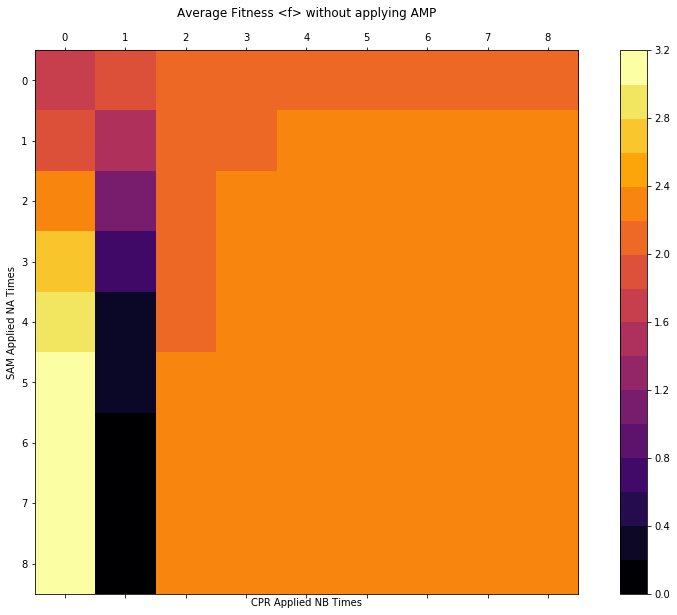

In [5]:
Ap = 8
avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit
cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
Z = ax.matshow(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> without applying AMP')
plt.colorbar(Z)

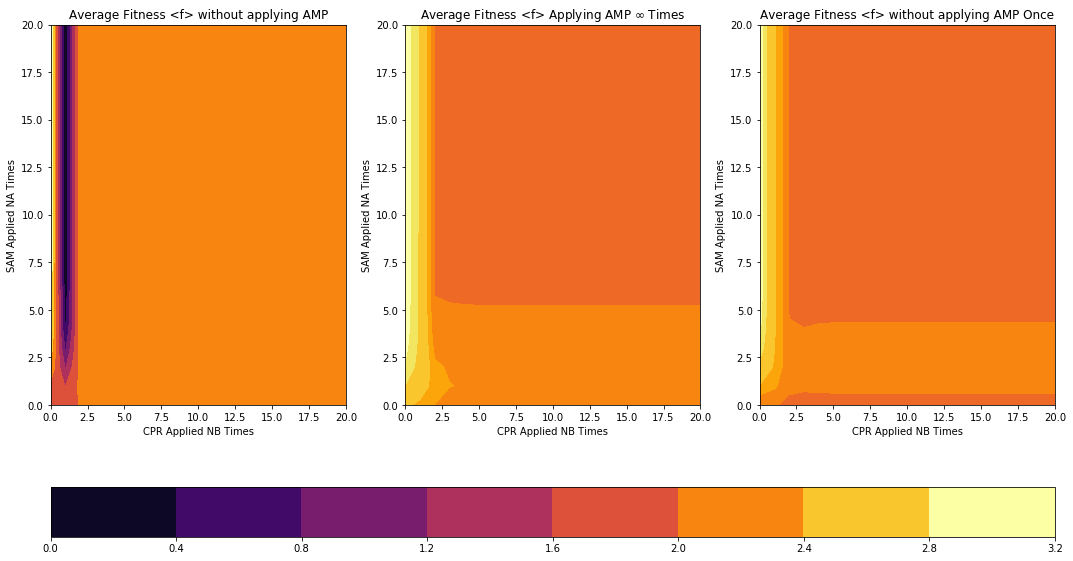

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18,10))

Ap = 20
avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit
cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
ax = axes[0]
Z0 = ax.contourf(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> without applying AMP')

avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB * AMP.tMat**100
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit
cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
ax = axes[1]
Z = ax.contourf(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> Applying AMP $\infty$ Times')

avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB * AMP.tMat
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit
cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
ax = axes[2]
Z = ax.contourf(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> without applying AMP Once')
fig.colorbar(Z0,  ax=axes.ravel().tolist(), orientation='horizontal')
plt.savefig('Contour.png')

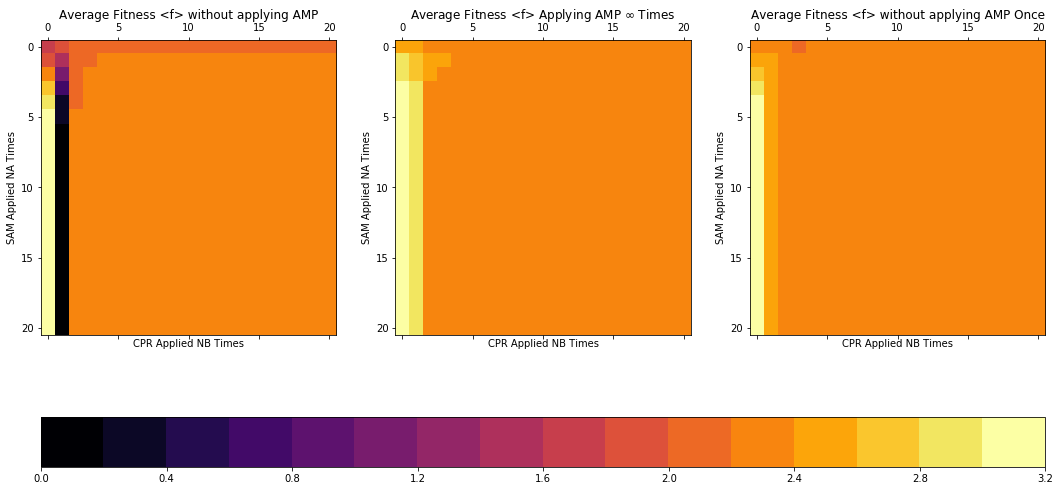

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18,10))

Ap = 20
avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit
cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
ax = axes[0]
Z0 = ax.matshow(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> without applying AMP')

avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB * AMP.tMat**100
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit
cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
ax = axes[1]
Z = ax.matshow(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> Applying AMP $\infty$ Times')

avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB * AMP.tMat
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit
cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
ax = axes[2]
Z = ax.matshow(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> without applying AMP Once')
fig.colorbar(Z0,  ax=axes.ravel().tolist(), orientation='horizontal')
plt.savefig('Matshow.png')

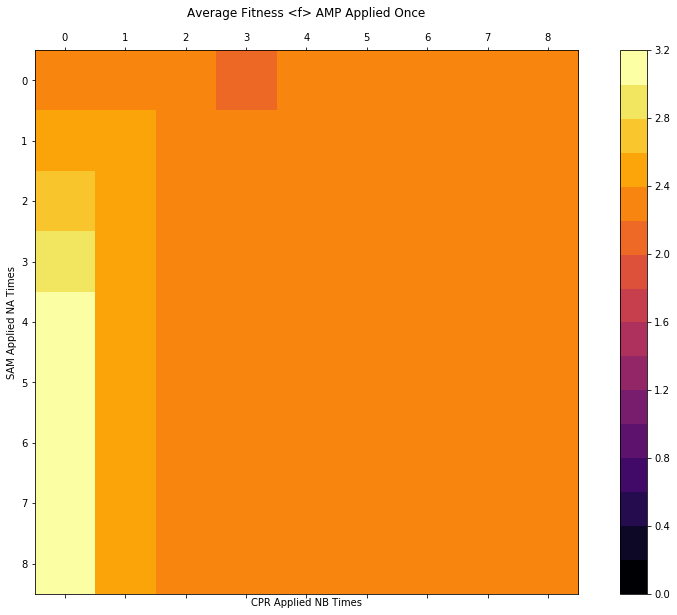

In [10]:
Ap = 8
avgMat = np.zeros([Ap+1, Ap+1])
for NA in range(0,Ap+1):
    for NB in range(0,Ap+1):
        SN = np.array(S0) * SAM.tMat**NA * CPR.tMat**NB * AMP.tMat
        AvgFit = np.dot(np.array(SN[0,:]), AMP.Fit)
        avgMat[NA, NB] = AvgFit

cmap = plt.cm.inferno
norm = mpl.colors.BoundaryNorm(np.arange(0,3.4,0.2), cmap.N)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
Z = ax.matshow(avgMat, cmap=cmap, norm=norm)
ax.set_xlabel('CPR Applied NB Times')
ax.set_ylabel('SAM Applied NA Times')
ax.set_title('Average Fitness <f> AMP Applied Once')
plt.colorbar(Z)